In [1]:
firstRun = False
if firstRun:
    !pip install -U numpy sympy matplotlib scipy --user

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy.optimize as sciop
from scipy.optimize import curve_fit
import scipy.stats as statspack
import sklearn.neighbors as skNN
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Phase Diagram Constructor

### Create Necessary Functions and Train the Model

#### Training the Model

In [3]:
def createArr(a1, a2, a3, ones, label):
    return np.stack((a1.T, a2.T, a3.T, label * ones.T),axis=1)

nPoints = 50

rhomArr = 0.577 + 0.05 * (0.5 - np.random.rand(nPoints))
ortArr = 0.707 + 0.05 * (0.5 - np.random.rand(nPoints))
tetArr = 0.95 + 0.05 * (0.5 - np.random.rand(nPoints))
onesArr = np.ones(nPoints)
zeroArr = np.zeros(nPoints)

domainListing = [(tetArr, zeroArr, zeroArr),                
                (zeroArr, tetArr, zeroArr),                
                (zeroArr, zeroArr, tetArr),                
                (ortArr, ortArr, zeroArr),
                (ortArr, zeroArr, ortArr),           
                (zeroArr, ortArr, ortArr),
                (rhomArr, rhomArr, rhomArr),
                (zeroArr, zeroArr, zeroArr)]

domainNames = ['Ta','Tb','Tc',
              'Oab','Oac','Obc',
              'R','P']

domains = []

for domain, label in zip(domainListing, range(len(domainListing))):
    domains.append(createArr(*domain, onesArr, label+1))
    
domains = np.concatenate(domains)

DomainColors = [[0.8867, 0.4335, 0.2734, 1.0],
                [0.3936, 0.1574, 0.8858, 1.0],
                [0.0, 0.0, 0.0, 1.0],
                [1.0, 0.7108, 0.0, 1.0],
                [0.3553, 0.9688, 0.3553, 1.0],
                [0.7511, 0.3936, 0.7511, 1.0],
                [1.0, 0.0, 0.0, 1.0],
                [0.0, 0.0, 1.0, 1.0]]

DomainDict = dict(zip(range(len(DomainColors)),DomainColors))

neigh = skNN.KNeighborsClassifier(n_neighbors=10)
neigh.fit(domains[:,:3], domains[:,3])

KNeighborsClassifier(n_neighbors=10)

### User Input

In [8]:
fileName='C:/Python/muThermo/OutputPictures.out'
parameter1='# Temperature'
parameter2='Hydrostatic Stress'

### Monodomain Phase Diagram

In [9]:
monodomain = pd.read_csv(fileName, delimiter=',')


tempDF = monodomain
testArr = np.abs(tempDF[['P1','P2','P3']].values)
domainRun = np.empty(len(testArr))
domainColors = np.zeros(domainRun.shape + (4,))

for i in range(len(testArr)):
    if np.linalg.norm(testArr[i,:]) < 0.1e-1:
        domainRun[i] = 8.0
    else:
        j = testArr[i,:] / np.linalg.norm(testArr[i,:])
        domainRun[i] = neigh.predict([j])
    domainColors[i] = DomainDict[domainRun[i]-1]
np.unique(domainRun)

array([3., 6., 7., 8.])

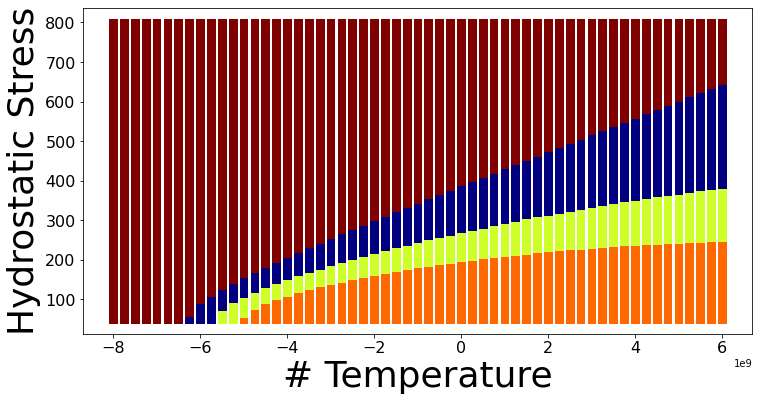

In [12]:
fig = plt.figure(figsize=[12,6])

plt.scatter( tempDF[parameter2],tempDF[parameter1].values, 
           c=domainRun, s=60, marker='s', cmap='jet')
# plt.colorbar()
# plt.ylim(0, 400)
# plt.xlim(min(tempDF[parameter1]), max(tempDF[parameter1]))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('{}'.format(parameter1), fontsize=36)
plt.ylabel('{}'.format(parameter2), fontsize=36)
plt.show()

## Material Properties

### User Input

In [77]:
fileName='C:/Python/muThermo/OutputPictures.out'
potentialFile = 'C:/Python/muThermo/muPot.in'
inputFile = 'C:/Python/muThermo/muInput.in'
materialDensity = 6020 #In kg/m3
heatCapacity = 500 #In Proper Units

### Create Energy Function and Property Tensor Formulations

In [92]:
p1, p2, p3, s1, s2, s3, s4, s5, s6 = sp.symbols('p1, p2, p3, sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6')
a1, a11, a111, a1111, a12, a112, a123, a1112, a1122, a1123 = sp.symbols('a1, a11, a111, a1111, a12, a112, a123, a1112, a1122, a1123')
S11, S12, S44, Q11, Q12, Q44 = sp.symbols('S11, S12, S44, Q11, Q12, Q44')
E1, E2, E3 = sp.symbols('E1 E2 E3')
T, XF = sp.symbols('T XF')

Gibbs = a1 * (p1**2 + p2**2 + p3**2) + a11 * (p1**4 + p2**4 + p3**4) + a111 * (p1**6 + p2**6 + p3**6)
Gibbs += a12 * (p1**2 * p2**2 + p1**2 * p3**2 + p2**2 * p3**2) + a112 * (p1**4 * (p2**2 + p3**2) + p2**4 * (p1**2 + p3**2) + p3**4 * (p2**2 + p1**2))
Gibbs += a123 * p1**2 * p2**2 * p3**2 + a1111 * (p1**8 + p2**8 + p3**8)
Gibbs += a1112 * (p1**6 * (p2**2 + p3**2) + p2**6 * (p1**2 + p3**2) + p3**6 * (p2**2 + p1**2))
Gibbs += a1122 * (p1**4 * p3**4 + p2**4 * p1**4 + p3**4 * p2**4)
Gibbs += a1123 * (p1**4 * p2**2 * p3**2 + p2**4 * p1**2 * p3**2 + p3**4 * p2**2 * p1**2)
Gibbs += sp.Rational('-1/2') * S11 * (s1**2 + s2**2 + s3**2) - S12 * (s1 * s2 + s2 * s3 + s1 * s3)
Gibbs += sp.Rational('-1/2') * S44 * (s4**2 + s5**2 + s6**2)
Gibbs += -Q11 * (s1 * p1**2 + s2 * p2**2 + s3 * p3**2) - Q44 * (s6 * p1 * p2 + s5 * p1 * p3 + s4 * p2 * p3)
Gibbs += -Q12 * (s1 * (p2**2 + p3**2) + s2 * (p1**2 + p3**2) + s3 * (p1**2 + p2**2))
Gibbs += -E1 * p1 - E2 * p2 - E3 * p3

u11, u22, u12 = sp.symbols('u11 u22 u12')

bcs = [
    Gibbs.diff(s1) + u11,
    Gibbs.diff(s2) + u22,
    Gibbs.diff(s6) + u12,
]

solveVars = [s1, s2, s3, s4, s5, s6]
solutions = sp.solve(bcs, solveVars)
Helmholtz = Gibbs + u11 * s1 + u22 * s2 + u12 * s6
pHelm = Helmholtz
Helmholtz = Helmholtz.subs(solutions)

inputPot = json.load(open(potentialFile, 'r'))
potDict = {}
potDict['a1'] = 0 ; potDict['a11'] = 0; potDict['a12'] = 0
potDict['a111'] = 0; potDict['a112'] = 0; potDict['a123'] = 0
potDict['a1111'] = 0; potDict['a1112'] = 0; potDict['a1122'] = 0; potDict['a1123'] = 0
potDict['b1'] = 0; potDict['b11'] = 0; potDict['b12'] = 0
potDict['S11'] = 0; potDict['S12'] = 0; potDict['S44'] = 0
potDict['Q11'] = 0; potDict['Q12'] = 0; potDict['Q44'] = 0
potDict['M11'] = 0; potDict['M12'] = 0; potDict['M44'] = 0
potDict['l11'] = 0; potDict['l12'] = 0; potDict['l44'] = 0

for key in inputPot.keys():
    if key in potDict.keys():
        potDict[key] = sp.sympify(inputPot[key])
        
for key in potDict.keys():
    Gibbs = Gibbs.subs(key, potDict[key])
    Helmholtz = Helmholtz.subs(key, potDict[key])

# Create the Energy Density Item for Each System
bulkEnergy = sp.lambdify([p1, p2, p3, T, XF, s1, s2, s3, s4, s5, s6, E1, E2, E3], Gibbs, 'numpy')
filmEnergy = sp.lambdify([p1, p2, p3, T, XF, u11, u22, s3, s4, s5, u12, E1, E2, E3], Helmholtz, 'numpy')
    
# Create the Dielectric Tensor For the Bulk System First
susceptabilityMatrix = []
for sym1 in [p1,p2,p3]:
    tempSusceptability = []
    for sym2 in [p1,p2,p3]:
        tempSusceptability.append(Gibbs.diff(sym1,sym2))
    susceptabilityMatrix.append(tempSusceptability)
    
bulkDielectricTensor = sp.lambdify([p1, p2, p3, T, XF, s1, s2, s3, s4, s5, s6, E1, E2, E3], sp.Matrix(susceptabilityMatrix), 'numpy')

# Create the Dielectric Tensor for the Film System Next
susceptabilityMatrix = []
for sym1 in [p1,p2,p3]:
    tempSusceptability = []
    for sym2 in [p1,p2,p3]:
        tempSusceptability.append(Helmholtz.diff(sym1,sym2))
    susceptabilityMatrix.append(tempSusceptability)
    
filmDielectricTensor = sp.lambdify([p1, p2, p3, T, XF, u11, u22, s3, s4, s5, u12, E1,E2,E3], sp.Matrix(susceptabilityMatrix), 'numpy')

# Create the Strain Tensor for the Bulk System First
etaDerives = []
for p in [p1,p2,p3]:
    tempEta = []
    for s in [s1,s2,s3,s4,s5,s6]:
        tempEta.append(-Gibbs.diff(s,p))
    etaDerives.append(tempEta)

bulkStrainTensor = sp.lambdify([p1, p2, p3, T, XF, s1, s2, s3, s4, s5, s6, E1, E2, E3], sp.Matrix(etaDerives), 'numpy')

# Create the Strain Tensor for the Film System Next
etaDerives = []
for p in [p1,p2,p3]:
    tempEta = []
    for s in [s1,s2,s3,s4,s5,s6]:
        tempEta.append(-pHelm.diff(s,p))
    etaDerives.append(tempEta)
    
etaDerives = sp.Matrix(etaDerives).subs(potDict)
filmStrainTensor = sp.lambdify([p1,p2,p3,T,XF,u11,u22,s3,s4,s5,u12,E1,E2,E3], etaDerives, 'numpy')

#Create caloric term for both Bulk and Film Systems
bulkCaloric = sp.lambdify([p1,p2,p3,T,XF,s1,s2,s3,s4,s5,s6,E1,E2,E3], -Gibbs.diff(T), 'numpy')
filmCaloric = sp.lambdify([p1,p2,p3,T,XF,u11,u22,s3,s4,s5,u12,E1,E2,E3],-Helmholtz.diff(T), 'numpy')

### Helper Functions

In [117]:
def createVariableDict(inputFile):
    inputDict = {}
    inputDict['System'] = 'Bulk'
    inputDict['Temperature'] = 300
    inputDict['Stress'] = [0,0,0,0,0,0]
    inputDict['Strain'] = [0,0,0,0,0,0]
    inputDict['Misfit'] = [0,0,0,0,0,0]
    inputDict['XF'] = 0.0
    inputDict['ElectricField'] = [0,0,0]
    inputDict['LElastic'] = 'True'
    inputDict['LElectric'] = 'False'
    inputDict['LPolar'] = 'True'
    inputDict['LOxytilt'] = 'False'
    inputDict['Property'] = []
    inputDict['SweepList'] = [[]]
    inputDict['SweepParameters'] = [[]]
    
    newDict = json.load(open(inputFile,'r'))
    
    for key in newDict.keys():
        if key in inputDict.keys():
            inputDict[key] = newDict[key]

    variableDict = {}
    
    variableDict['Temperature'] = inputDict['Temperature']
    variableDict['XF'] = inputDict['XF']

    if inputDict['System'].lower() == 'film':
        if inputDict['LElastic'].lower() == 'true':
            variableDict['MisfitXX'] = inputDict['Misfit'][0]
            variableDict['MisfitYY'] = inputDict['Misfit'][1]
            variableDict['StressZZ'] = inputDict['Misfit'][2]
            variableDict['StressYZ'] = inputDict['Misfit'][3]
            variableDict['StressXZ'] = inputDict['Misfit'][4]
            variableDict['MisfitXY'] = inputDict['Misfit'][5]
    else:
        if inputDict['LElastic'].lower() == 'true':
            variableDict['StressXX'] = inputDict['Stress'][0]
            variableDict['StressYY'] = inputDict['Stress'][1]
            variableDict['StressZZ'] = inputDict['Stress'][2]
            variableDict['StressYZ'] = inputDict['Stress'][3]
            variableDict['StressXZ'] = inputDict['Stress'][4]
            variableDict['StressXY'] = inputDict['Stress'][5]

    if inputDict['LElectric'].lower() == 'true':
        variableDict['ElectricFieldx'] = inputDict['ElectricField'][0]
        variableDict['ElectricFieldy'] = inputDict['ElectricField'][1]
        variableDict['ElectricFieldz'] = inputDict['ElectricField'][2]

    return variableDict
    
def updateVariableDict(variableDict, value, param):
    
    if param.lower() == 'isotropic misfit':
        variableDict['MisfitXX'] = value
        variableDict['MisfitYY'] = value
    elif param.lower() == 'hydrostatic stress':
        variableDict['StressXX'] = value
        variableDict['StressYY'] = value
        variableDict['StressZZ'] = value
    elif param.lower() == 'electricfield':
        variableDict['ElectricFieldx'] = value
        variableDict['ElectricFieldy'] = value
        variableDict['ElectricFieldz'] = value
    else:
        variableDict[param] = value

    return variableDict

### Energy Density

In [133]:
fileInput = json.load(open(inputFile,'r'))
fileOutput = pd.read_csv(fileName)
fileOutput.columns = fileOutput.columns.str.replace("_", "")
fileOutput.columns = fileOutput.columns.str.replace(" ", "")
polarData = fileOutput[['P1','P2','P3']].values
energyDensity = np.zeros(len(polarData))
variableDictionary = createVariableDict(inputFile)

#Get Length of Parameter Sweep
parameterList = fileInput['SweepParameters']

if len(parameterList)==1:
    for i in range(len(polarData)):
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.loc[i,parameterList[0]], parameterList[0])
        if fileInput['System'].lower == 'bulk':
            energyDensity[i] = bulkEnergy(*polarData[i,:], variableDictionary.values)
        if str(fileInput['System'].lower()) == str('film'):
            energyDensity[i] = filmEnergy(*polarData[i,:], *list(variableDictionary.values()))
            
if len(parameterList)==2:
    for i in range(len(polarData)):
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,0], parameterList[0])
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,1], parameterList[1])
        if str(fileInput['System'].lower()) == str('bulk'):
            energyDensity[i] = bulkEnergy(*polarData[i,:], *list(variableDictionary.values()))
        if str(fileInput['System'].lower()) == str('film'):
            energyDensity[i] = filmEnergy(*polarData[i,:], *list(variableDictionary.values()))
            
if len(parameterList)==3:
    for i in range(len(polarData)):
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,0], parameterList[0])
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,1], parameterList[1])
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,2], parameterList[2])
        if str(fileInput['System'].lower()) == str('bulk'):
            energyDensity[i] = bulkEnergy(*polarData[i,:], *list(variableDictionary.values()))
        if str(fileInput['System'].lower()) == str('film'):
            energyDensity[i] = filmEnergy(*polarData[i,:], *list(variableDictionary.values()))

fileOutput['Energy'] = energyDensity

print('Free Energy has been calculated for your system. It is located in column "Energy" in the fileOutput dataframe.')


Free Energy has been calculated for your system. It is located in column "Energy" in the fileOutput dataframe.


### Dielectric Tensor

In [157]:
fileInput = json.load(open(inputFile,'r'))
fileOutput = pd.read_csv(fileName)
fileOutput.columns = fileOutput.columns.str.replace("_", "")
fileOutput.columns = fileOutput.columns.str.replace(" ", "")
polarData = fileOutput[['P1','P2','P3']].values
k11, k22, k33, k12, k13, k23 = np.zeros(len(polarData)), np.zeros(len(polarData)), np.zeros(len(polarData)), np.zeros(len(polarData)), np.zeros(len(polarData)), np.zeros(len(polarData))
variableDictionary = createVariableDict(inputFile)

#Get Length of Parameter Sweep
parameterList = fileInput['SweepParameters']

if len(parameterList)==1:
    for i in range(len(polarData)):
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.loc[i,parameterList[0]], parameterList[0])
        if fileInput['System'].lower() == 'bulk':
            diTen = bulkDielectricTensor(*polarData[i,:], *list(variableDictionary.values()))
        if str(fileInput['System'].lower()) == str('film'):
            diTen = filmDielectricTensor(*polarData[i,:], *list(variableDictionary.values()))
        diTen = (1 + np.abs(np.linalg.inv(diTen))/8.85e-12)
        k11[i] = diTen[0,0] ; k22[i] = diTen[1,1]; k33[i] = diTen[2,2]
        k12[i] = diTen[0,1] ; k23[i] = diTen[1,2]; k13[i] = diTen[0,2]
            
if len(parameterList)==2:
    for i in range(len(polarData)):
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,0], parameterList[0])
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,1], parameterList[1])
#         print(*polarData[i,:], *list(variableDictionary.values()))
        if fileInput['System'].lower() == 'bulk':
            diTen = bulkDielectricTensor(*polarData[i,:], *list(variableDictionary.values()))
        if str(fileInput['System'].lower()) == str('film'):
            diTen = filmDielectricTensor(*polarData[i,:], *list(variableDictionary.values()))
        diTen = np.abs(np.linalg.inv(diTen))
        diTen = (1 + diTen/8.85e-12)
        k11[i] = diTen[0,0] ; k22[i] = diTen[1,1]; k33[i] = diTen[2,2]
        k12[i] = diTen[0,1] ; k23[i] = diTen[1,2]; k13[i] = diTen[0,2]
            
if len(parameterList)==3:
    for i in range(len(polarData)):
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,0], parameterList[0])
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,1], parameterList[1])
        variableDictionary = updateVariableDict(variableDictionary, fileOutput.iloc[i,2], parameterList[2])
        if fileInput['System'].lower() == 'bulk':
            diTen = bulkDielectricTensor(*polarData[i,:], *list(variableDictionary.values()))
        if str(fileInput['System'].lower()) == str('film'):
            diTen = filmDielectricTensor(*polarData[i,:], *list(variableDictionary.values()))
        diTen = (1 + np.abs(np.linalg.inv(diTen))/8.85e-12)
        k11[i] = diTen[0,0] ; k22[i] = diTen[1,1]; k33[i] = diTen[2,2]
        k12[i] = diTen[0,1] ; k23[i] = diTen[1,2]; k13[i] = diTen[0,2]
        
fileOutput['K11'] = k11
fileOutput['K22'] = k22
fileOutput['K33'] = k33
fileOutput['K12'] = k12
fileOutput['K13'] = k13
fileOutput['K23'] = k23
fileOutput[(fileOutput['HydrostaticStress']==-1e9)]

,#Temperature,HydrostaticStress,P1,P2,P3,k11,k22,k33,k23,k13,...,d33,d31,d15,d24,K11,K22,K33,K12,K13,K23
28,50.0,-1.000000e+09,0.233156,0.233156,2.331557e-01,398.828512,398.828512,398.828512,121.873530,121.873530,...,1.357014e+02,-4.145634e+01,3.103882e+01,3.103882e+01,398.828512,398.828512,398.828512,121.873530,121.873530,121.873530
85,51.0,-1.000000e+09,0.233133,0.233133,2.331327e-01,399.181924,399.181924,399.181924,122.018308,122.018308,...,1.357947e+02,-4.147905e+01,3.106557e+01,3.106557e+01,399.181924,399.181924,399.181924,122.018308,122.018308,122.018308
142,52.0,-1.000000e+09,0.233108,0.233108,2.331077e-01,399.567050,399.567050,399.567050,122.176109,122.176109,...,1.358963e+02,-4.150378e+01,3.109472e+01,3.109472e+01,399.567050,399.567050,399.567050,122.176109,122.176109,122.176109
199,53.0,-1.000000e+09,0.233081,0.233081,2.330806e-01,399.985168,399.985168,399.985168,122.347463,122.347463,...,1.360066e+02,-4.153063e+01,3.112636e+01,3.112636e+01,399.985168,399.985168,399.985168,122.347463,122.347463,122.347463
256,54.0,-1.000000e+09,0.233051,0.233051,2.330513e-01,400.437514,400.437514,400.437514,122.532888,122.532888,...,1.361259e+02,-4.155966e+01,3.116060e+01,3.116060e+01,400.437514,400.437514,400.437514,122.532888,122.532888,122.532888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42550,796.0,-1.000000e+09,0.000000,0.000000,0.000000e+00,260.725600,260.725600,260.725600,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,260.725600,260.725600,260.725600,1.000000,1.000000,1.000000
42607,797.0,-1.000000e+09,0.000000,0.000000,0.000000e+00,260.137900,260.137900,260.137900,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,260.137900,260.137900,260.137900,1.000000,1.000000,1.000000
42664,798.0,-1.000000e+09,0.000000,0.000000,0.000000e+00,259.552835,259.552835,259.552835,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,259.552835,259.552835,259.552835,1.000000,1.000000,1.000000
42721,799.0,-1.000000e+09,0.000000,0.000000,0.000000e+00,258.970386,258.970386,258.970386,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,258.970386,258.970386,258.970386,1.000000,1.000000,1.000000


### Piezoelectric Tensor

### Caloric Properties

### Piezocaloric Properties